In [1]:
from collections import defaultdict
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import scvelo as scv
#import velocyto as vcy
from os import listdir
from os.path import isfile, join
import glob
from collections import Counter
import loompy as lp
import numba
import llvmlite
import scipy.sparse

# import mnnpy
from matplotlib import colors

In [2]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0.2, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [3]:
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0rc0 python-igraph==0.9.6 louvain==0.7.0 pynndescent==0.5.4


In [4]:
pack_list = [numba,llvmlite,lp,pd,sns,scv]
for pack in pack_list:
    print(str(pack), pack.__version__)
    

<module 'numba' from 'C:\\Users\\giovanni\\anaconda3\\envs\\python39\\lib\\site-packages\\numba\\__init__.py'> 0.54.0
<module 'llvmlite' from 'C:\\Users\\giovanni\\anaconda3\\envs\\python39\\lib\\site-packages\\llvmlite\\__init__.py'> 0.37.0
<module 'loompy' from 'C:\\Users\\giovanni\\AppData\\Roaming\\Python\\Python39\\site-packages\\loompy\\__init__.py'> 3.0.6
<module 'pandas' from 'C:\\Users\\giovanni\\anaconda3\\envs\\python39\\lib\\site-packages\\pandas\\__init__.py'> 1.3.3
<module 'seaborn' from 'C:\\Users\\giovanni\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'> 0.11.2
<module 'scvelo' from 'C:\\Users\\giovanni\\AppData\\Roaming\\Python\\Python39\\site-packages\\scvelo\\__init__.py'> 0.2.4


In [5]:
scv.set_figure_params('scanpy')  # for beautified visualization

In [6]:
sc.set_figure_params(dpi_save=500, frameon=True,
                     vector_friendly=True, fontsize=14,
                     figsize=None, color_map=None, format='pdf',
                     facecolor=None, transparent=True, ipython_format='png2x')


In [7]:
Axo_path = '../Seurat/integrated_CT_Yu_Gerber.h5ad'
axo = sc.read_h5ad(Axo_path)

In [8]:
axo.obs["dataset"] = axo.obs["dataset"].cat.rename_categories({'Andy': 'Yu'})
axo.obs["dataset"].cat.set_categories(['Yu', 'Gerber'], inplace=True)
axo.obs['cellTypes'] = axo.obs["cellTypes"].cat.set_categories(['Blastema_8dpa', 'Blastema_11dpa', 'Blastema_18dpa', 'mid', 'late', 'pal'])

In [9]:
axo

AnnData object with n_obs × n_vars = 669 × 99218
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Stage', 'Assay', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'dataset', 'cellTypes', 'SCT_snn_res.1', 'integrated_snn_res.0.4'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [10]:
axo.obs['cellTypes']

SRR7368386      Blastema_11dpa
SRR7368387      Blastema_11dpa
SRR7368388      Blastema_11dpa
SRR7368389      Blastema_11dpa
SRR7368390      Blastema_11dpa
                     ...      
mid11_07_I02               mid
mid11_07_I04               mid
mid11_07_I07               mid
mid11_07_I09               mid
mid11_07_I10               mid
Name: cellTypes, Length: 669, dtype: category
Categories (6, object): ['Blastema_8dpa', 'Blastema_11dpa', 'Blastema_18dpa', 'mid', 'late', 'pal']

In [11]:
axo.obs["dataset"]

SRR7368386      Gerber
SRR7368387      Gerber
SRR7368388      Gerber
SRR7368389      Gerber
SRR7368390      Gerber
                 ...  
mid11_07_I02        Yu
mid11_07_I04        Yu
mid11_07_I07        Yu
mid11_07_I09        Yu
mid11_07_I10        Yu
Name: dataset, Length: 669, dtype: category
Categories (2, object): ['Yu', 'Gerber']

Keep repeat filtered genes

In [12]:
filtered_symbol_unique = pd.read_csv("../geneid_symbol_filtered_unique.csv").set_index("gene_id")

In [13]:
## Filter by repeats
new_vars = axo.var.merge(filtered_symbol_unique, how='inner', left_index=True, right_index=True)
axo = axo[:,list(new_vars.index)]
axo.var = new_vars
axo.var.set_index("symbol", inplace=True)
axo.var_names_make_unique()

In [14]:
axo

AnnData object with n_obs × n_vars = 669 × 52730
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Stage', 'Assay', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'dataset', 'cellTypes', 'SCT_snn_res.1', 'integrated_snn_res.0.4'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

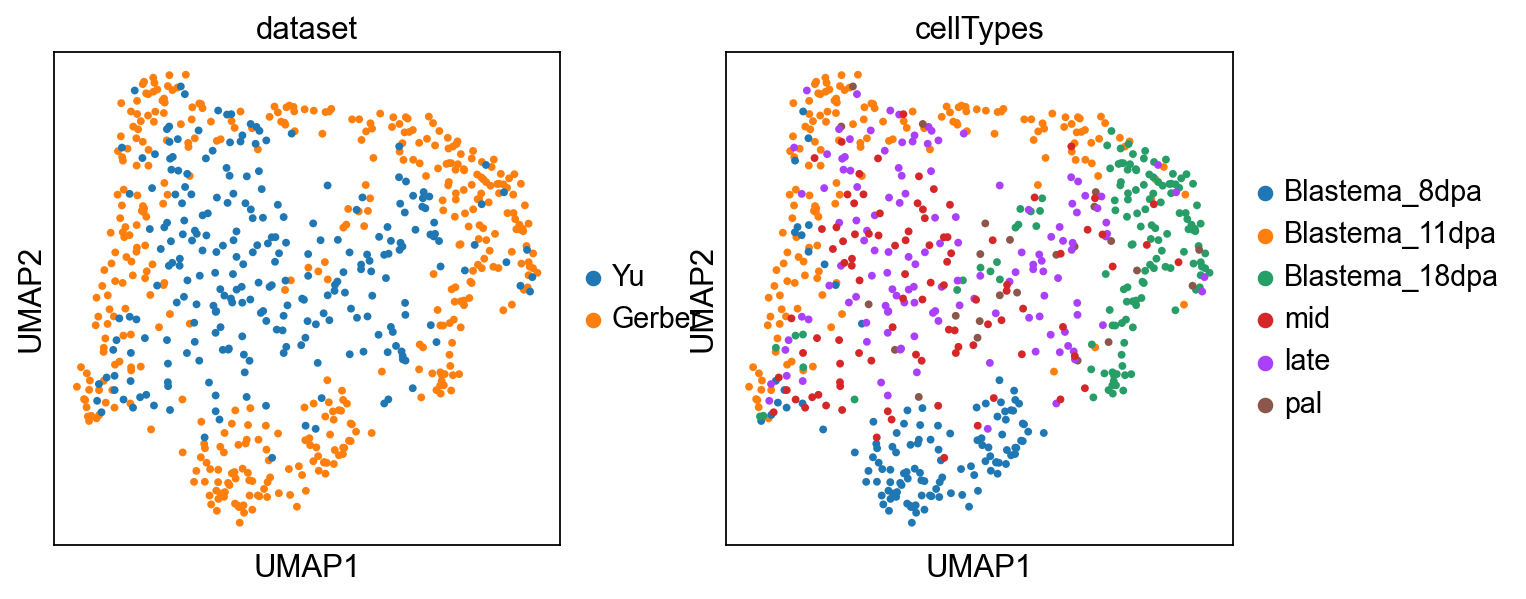

In [15]:
sc.pl.umap(axo, color=['dataset','cellTypes'], size=50)

In [16]:
axo.uns['dataset_colors'] = ['#d62728', "#D5D5D5"]

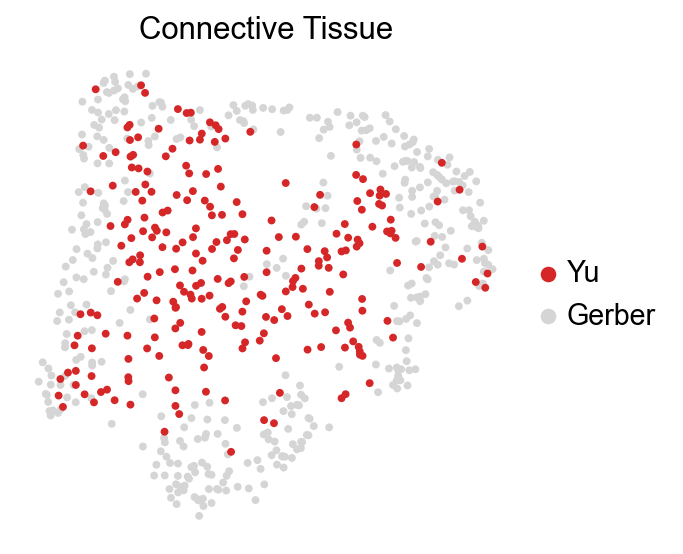

In [17]:
sc.pl.umap(axo, color=['dataset'], size = 50, title="Connective Tissue", frameon=False, save="Yu_Gerber_ConnectiveTissue")

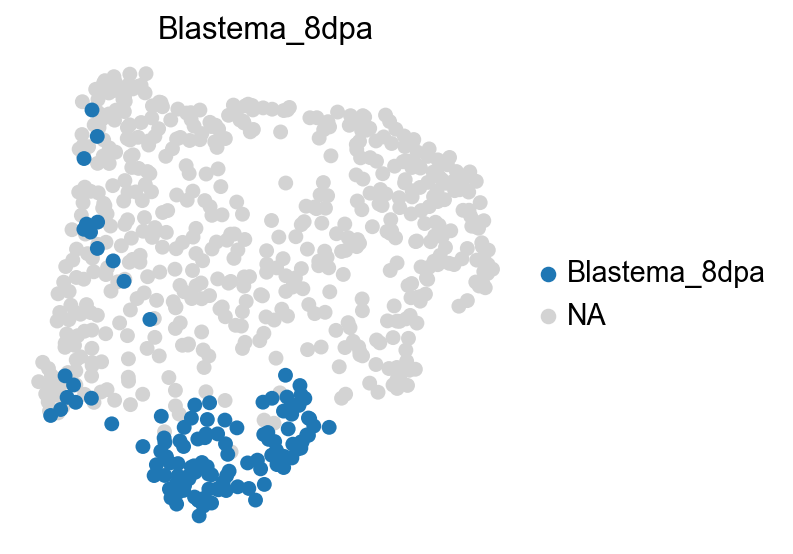

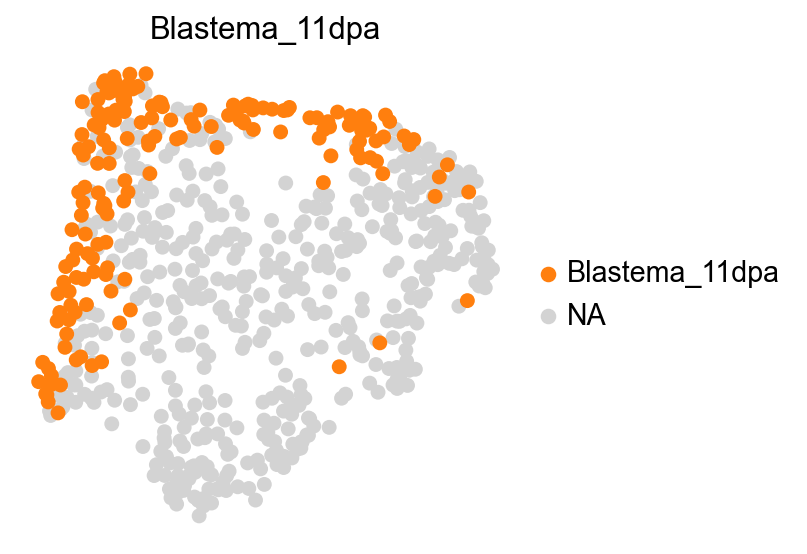

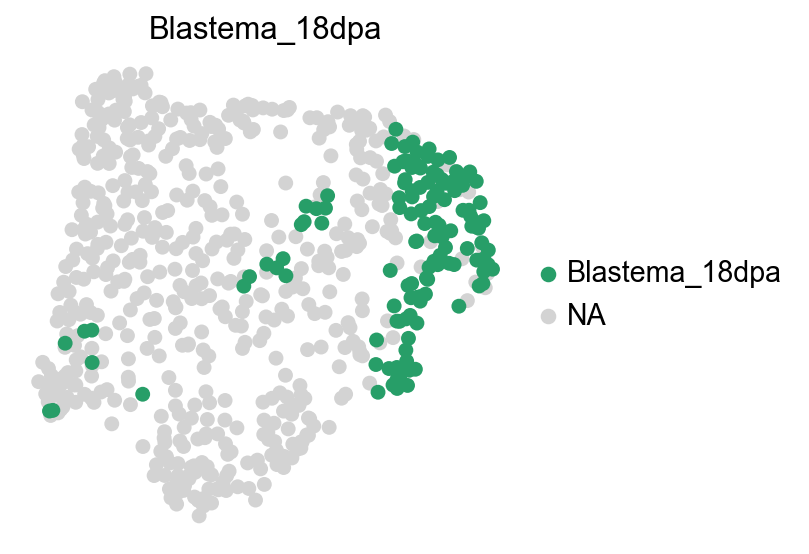

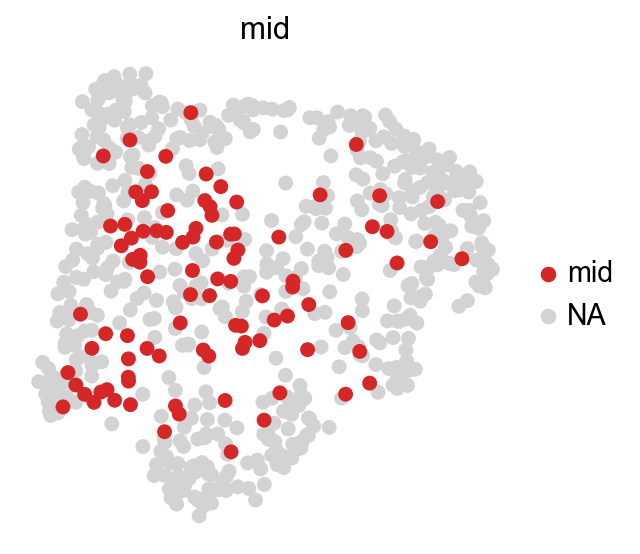

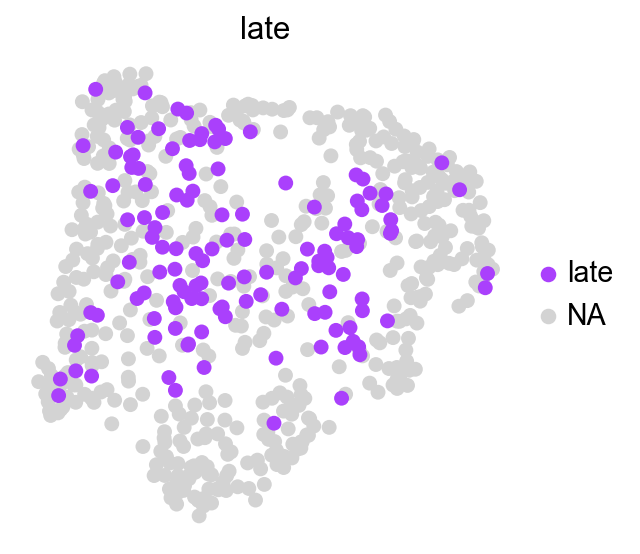

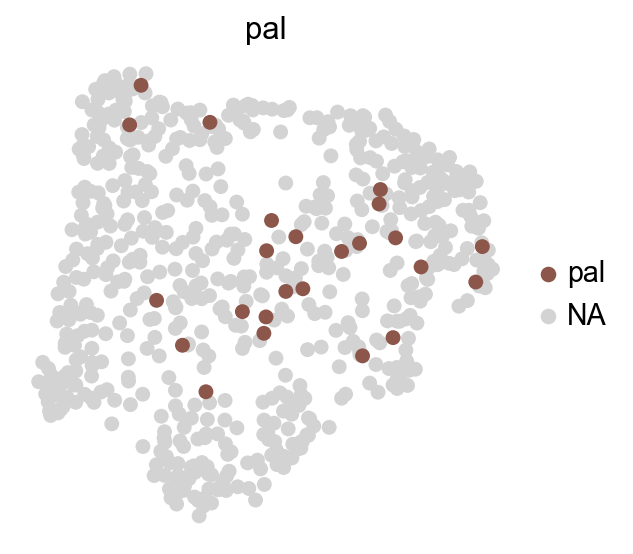

In [18]:
 for batch in ['Blastema_8dpa', 'Blastema_11dpa', 'Blastema_18dpa', 'mid', 'late', 'pal']:
     sc.pl.umap(axo, color='cellTypes',
                groups=[batch],
                frameon = False,
                title = batch,
                save = batch+".pdf"
               )

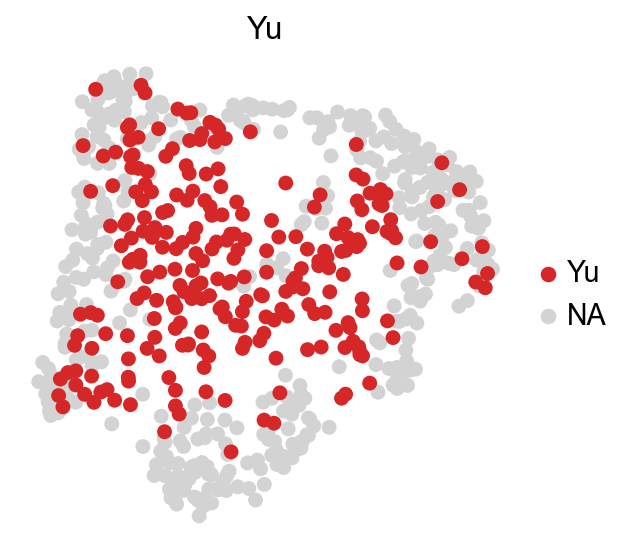

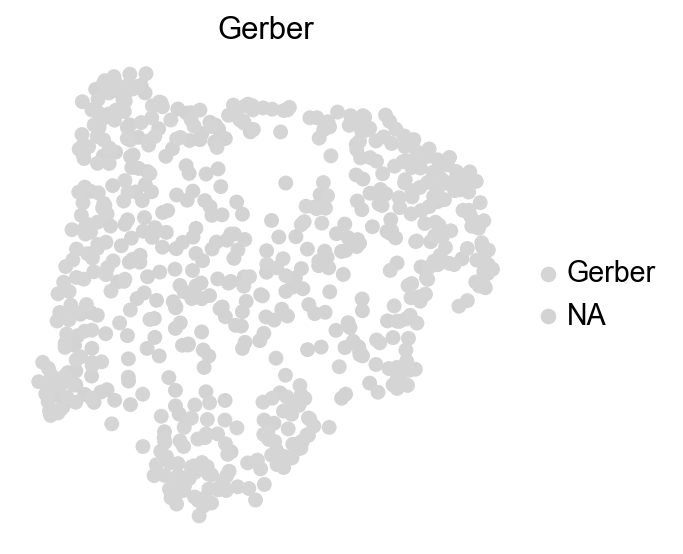

In [19]:
 for batch in ['Yu','Gerber']:
     sc.pl.umap(axo, color='dataset',
                groups=[batch],
                frameon = False,
                title = batch,
                save = batch+".pdf"
               )

In [20]:
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]

In [21]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in axo.var_names]

In [22]:
sc.pp.normalize_total(axo, target_sum=1e4)
sc.pp.log1p(axo)
# scale and store results in layer
axo.layers['scaled'] = sc.pp.scale(axo, copy=True).X

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


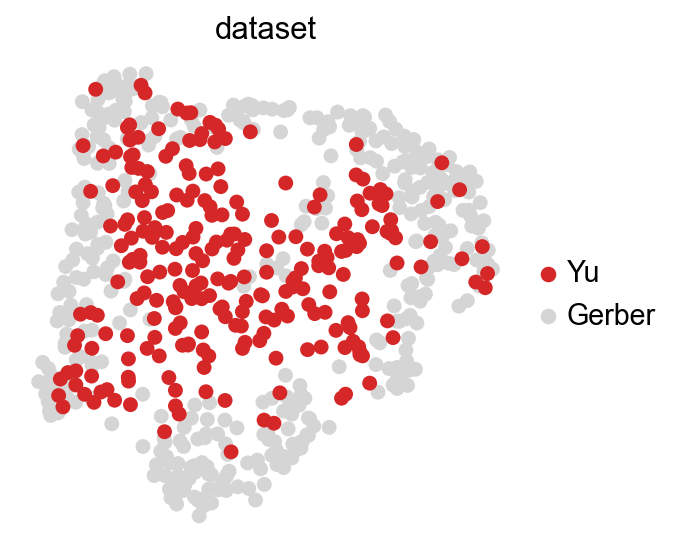

In [23]:
sc.pl.umap(axo, color=['dataset'], frameon=False)


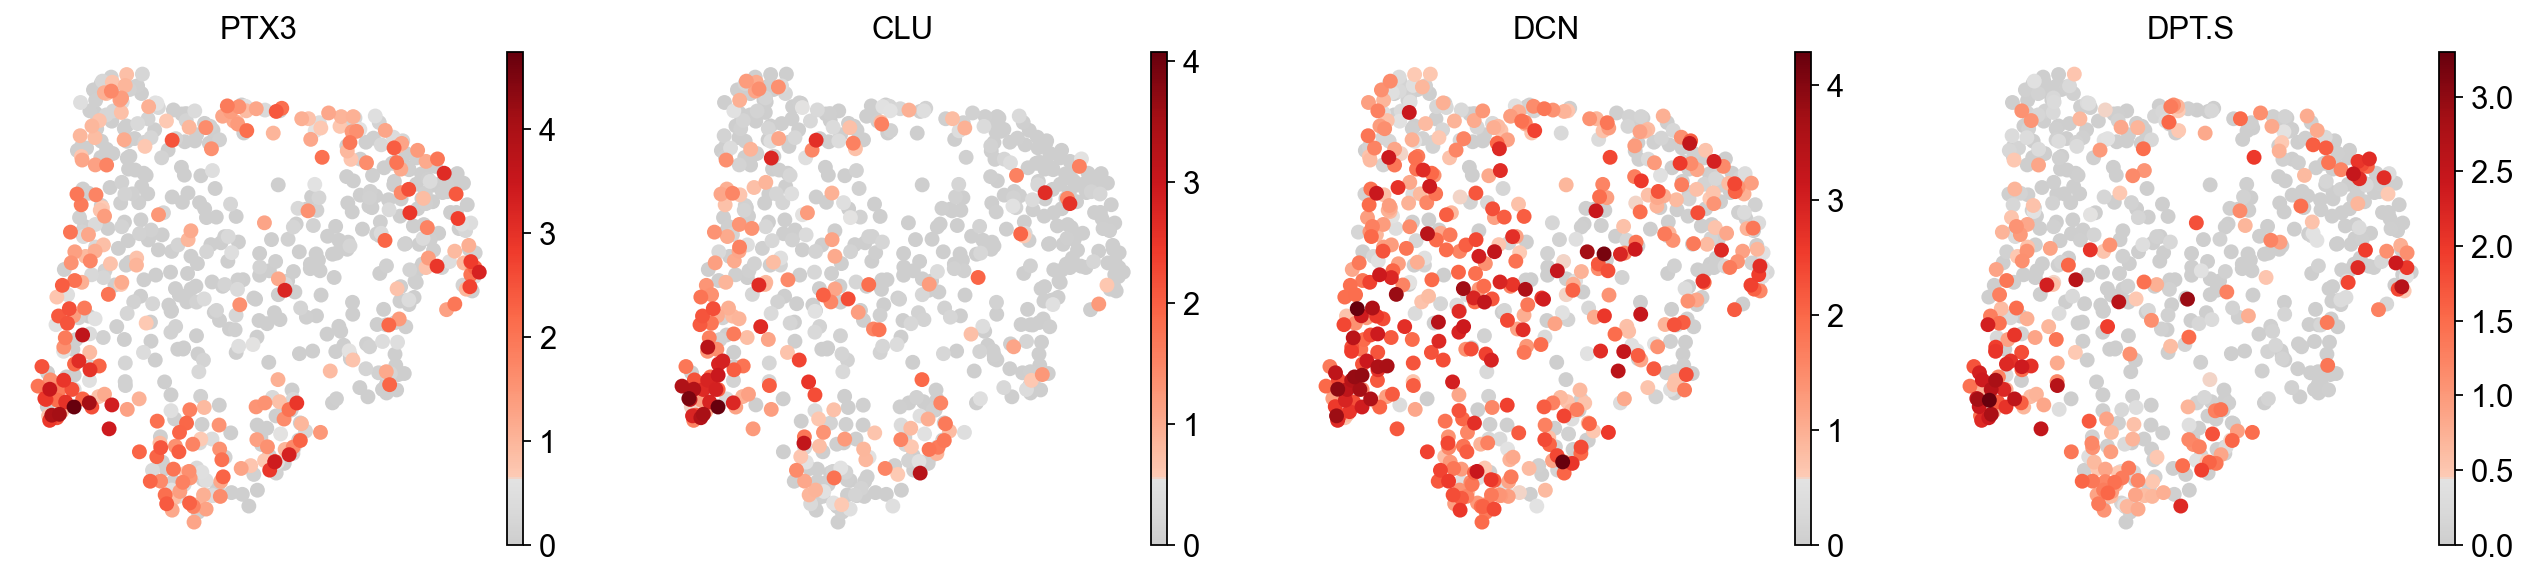

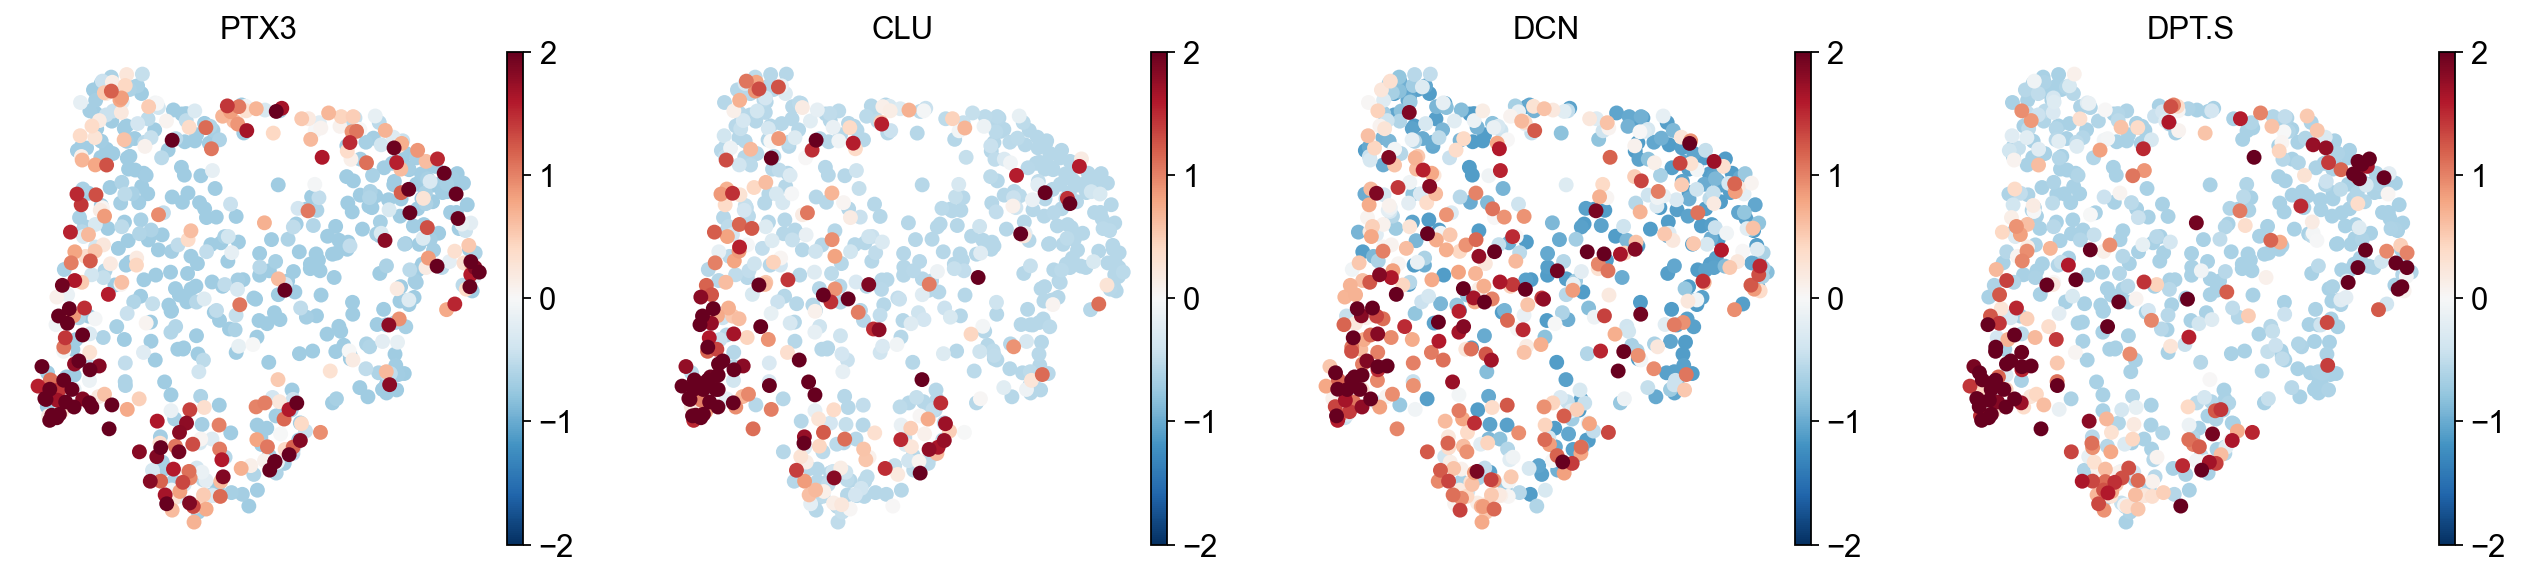

In [24]:
sc.pl.umap(axo, color=['PTX3','CLU','DCN','DPT.S'], use_raw=False, frameon=False, color_map = mymap)

sc.pl.umap(axo, color=['PTX3','CLU','DCN','DPT.S'],layer='scaled',
                                     vmin=-2,
                                     vmax=2,
                                     frameon=False,
                                     color_map='RdBu_r', use_raw=False)

# sc.pl.draw_graph(axo, color=['PTX3','CLU','DCN','DPT.S'],layer='scaled',
#                                      vmin=-2,
#                                      vmax=2,
#                                      color_map='RdBu_r', use_raw=False)

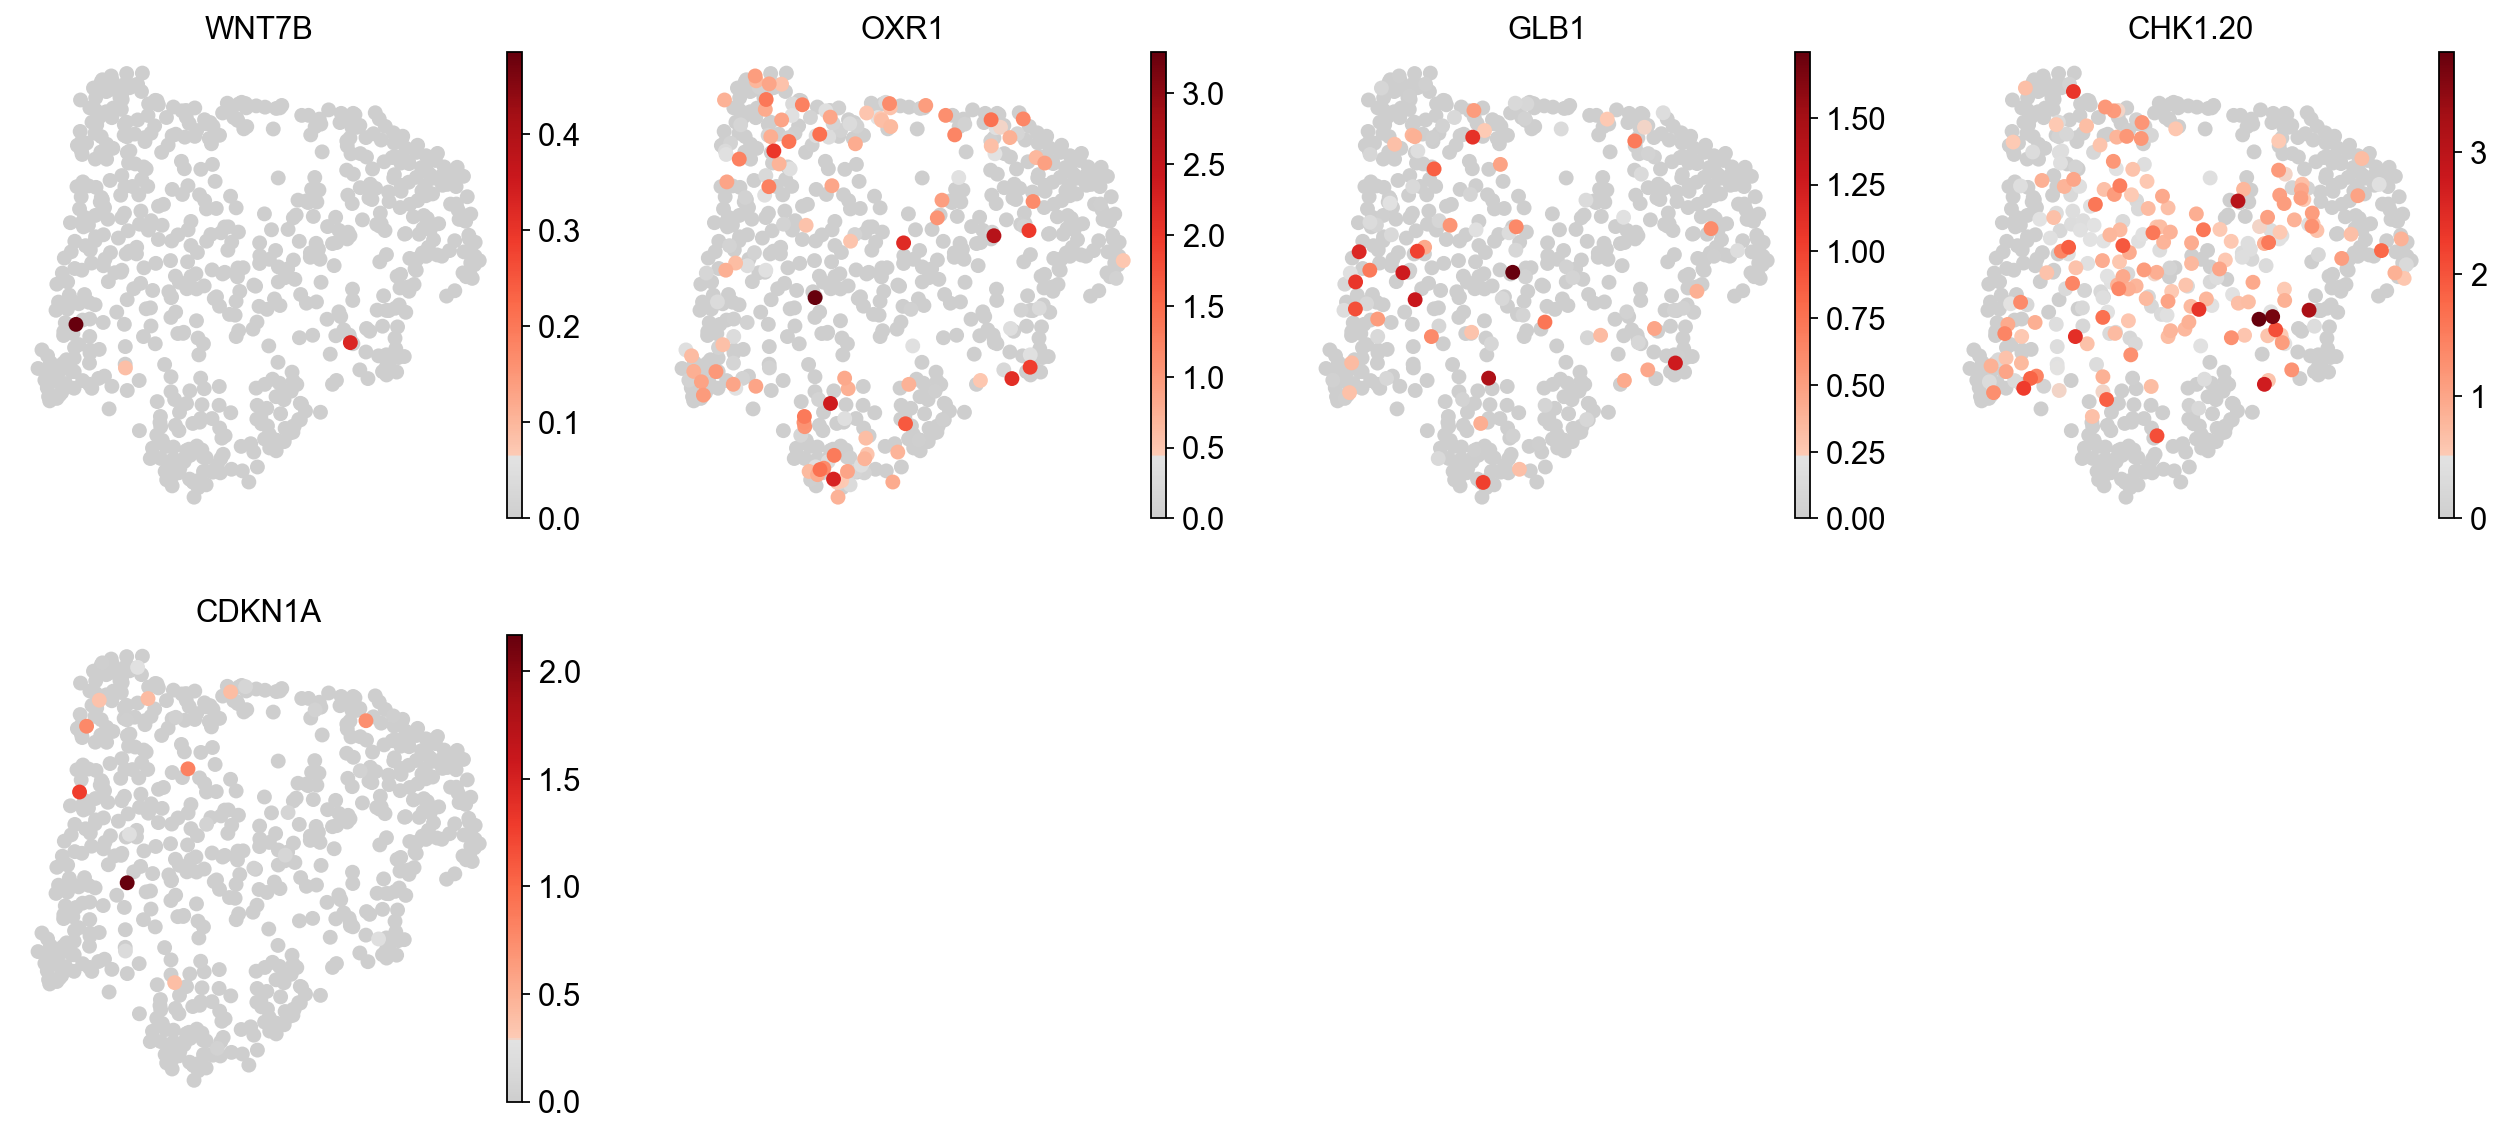

In [25]:
sc.pl.umap(axo, color=['WNT7B','OXR1','GLB1','CHK1.20','CDKN1A'], use_raw=False, frameon=False, color_map = mymap)


In [26]:
common = pd.read_csv("../Bulk/common_UPgenes_symbolANDid.csv")
common.head()

gene_id          symbol
0  AMEX60DD002123  AMEX60DD002123
1  AMEX60DD002209  AMEX60DD002209
2  AMEX60DD003570  AMEX60DD003570
3  AMEX60DD004025  AMEX60DD004025
4  AMEX60DD004026  AMEX60DD004026

In [27]:
sc.tl.score_genes(axo, 
                      common.symbol, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='CommonBulkScore', 
                      random_state=0, copy=False, use_raw=False)

computing score 'CommonBulkScore'
    finished: added
    'CommonBulkScore', score of gene set (adata.obs).
    549 total control genes are used. (0:00:00)


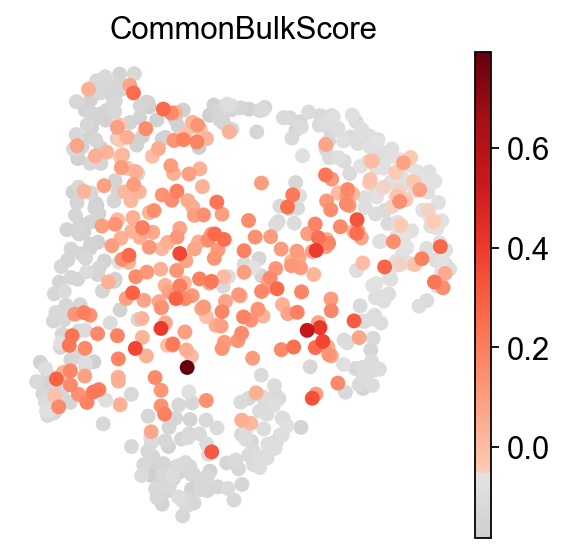

In [28]:
sc.pl.umap(axo, color=['CommonBulkScore'], use_raw=False, color_map = mymap, frameon=False)

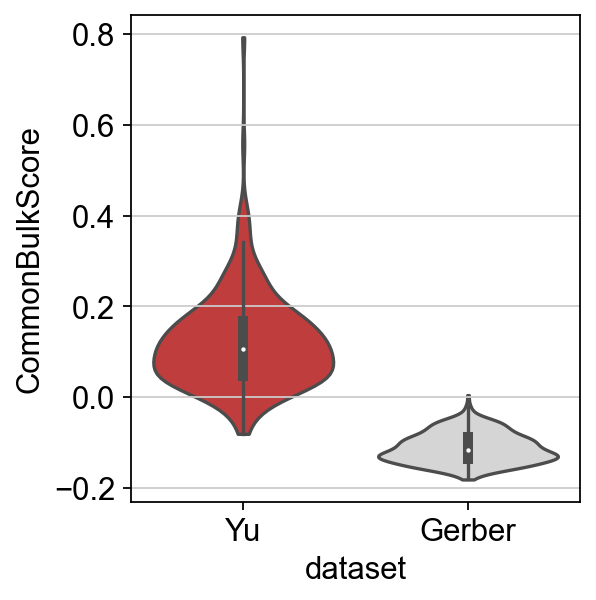

In [29]:
sc.pl.violin(axo, ['CommonBulkScore'], groupby='dataset' , stripplot=False, inner='box')

In [30]:
sc.tl.score_genes_cell_cycle(axo, s_genes=s_genes, g2m_genes=g2m_genes)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    301 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    515 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [31]:
axo

AnnData object with n_obs × n_vars = 669 × 52730
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Stage', 'Assay', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'dataset', 'cellTypes', 'SCT_snn_res.1', 'integrated_snn_res.0.4', 'CommonBulkScore', 'S_score', 'G2M_score', 'phase'
    var: 'name'
    uns: 'dataset_colors', 'cellTypes_colors', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'scaled'

... storing 'phase' as categorical


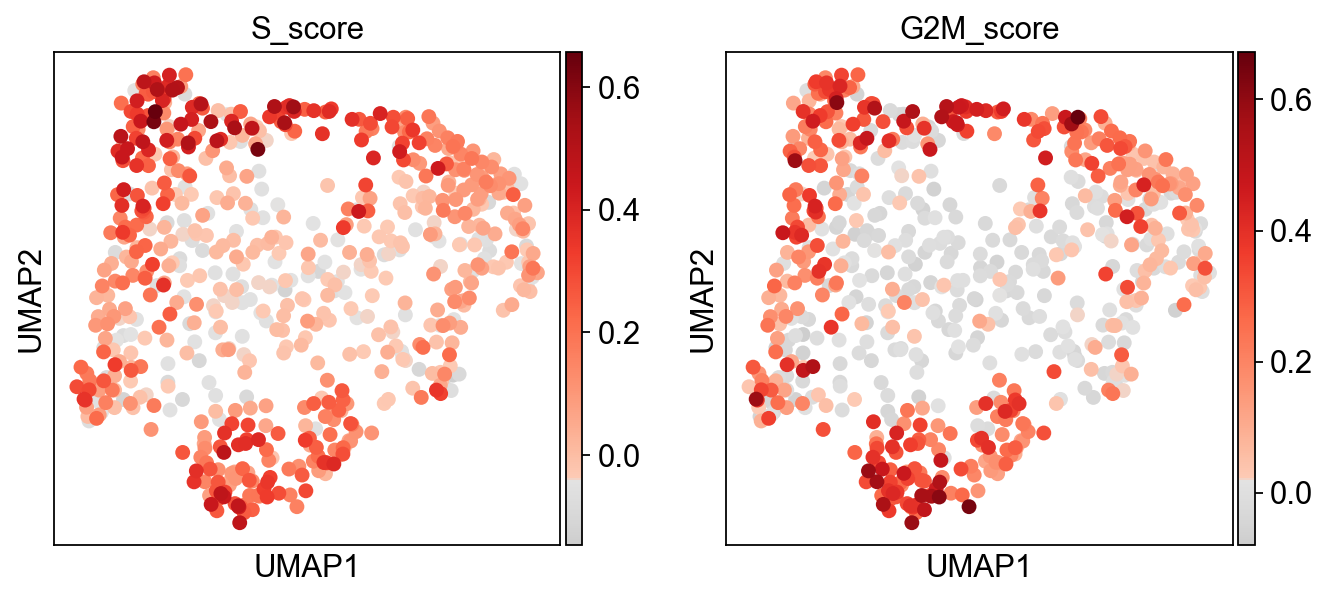

In [32]:
sc.pl.umap(axo, color=['S_score', 'G2M_score'], use_raw=False, color_map = mymap)

In [33]:
sc.tl.embedding_density(axo, basis='umap', groupby='phase')



computing density on 'umap'
--> added
    'umap_density_phase', densities (adata.obs)
    'umap_density_phase_params', parameter (adata.uns)


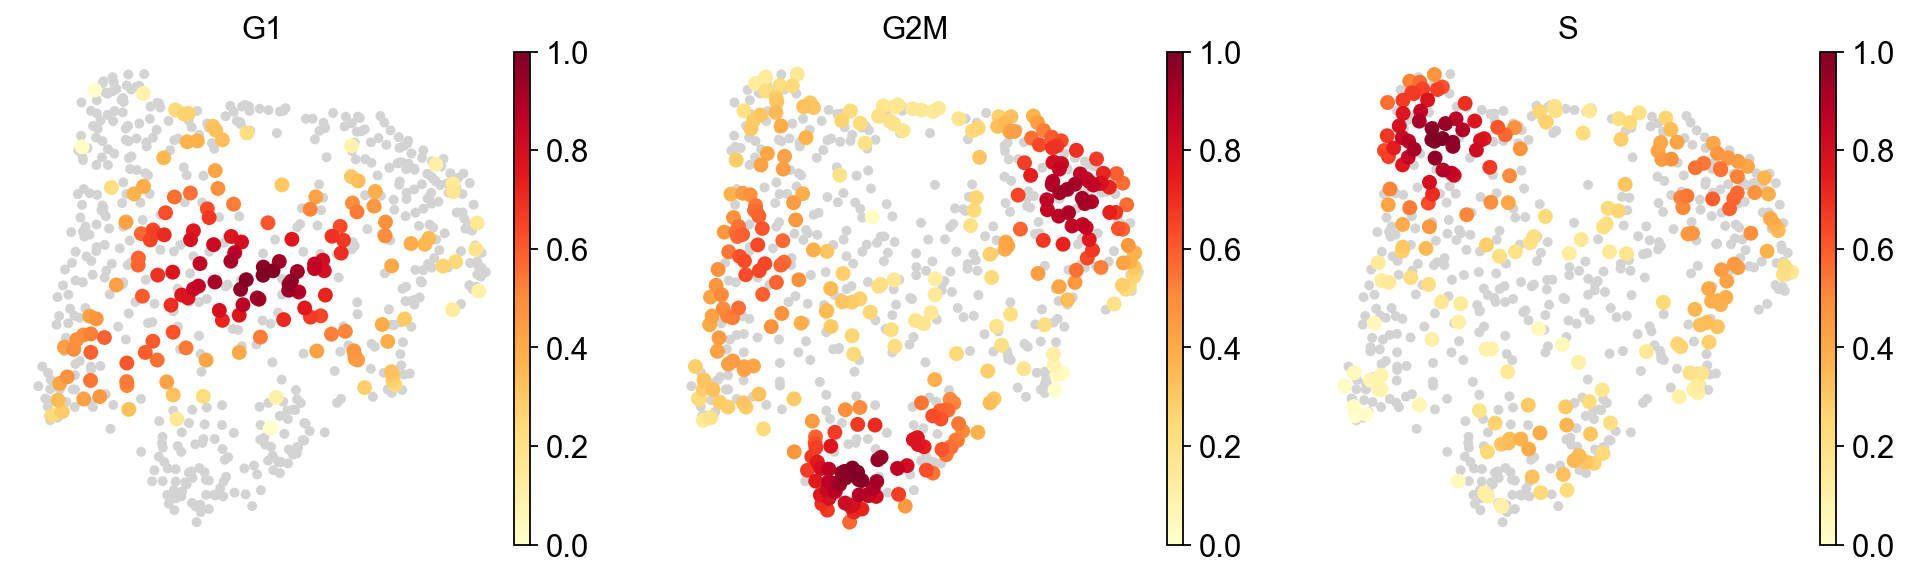

In [34]:
sc.pl.embedding_density(axo, basis='umap', key='umap_density_phase', frameon=False)

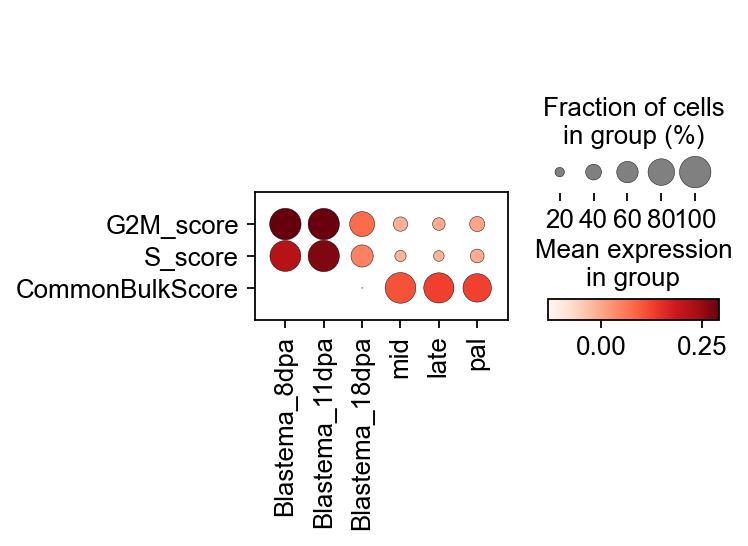

In [35]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names=['G2M_score', 'S_score', 'CommonBulkScore'],
              swap_axes=True,
              save="_CT_compare_CellCycle_commonScore"
             )

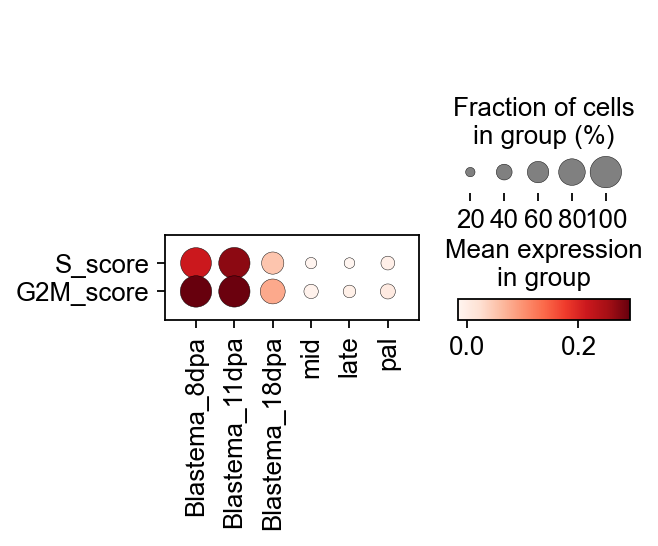

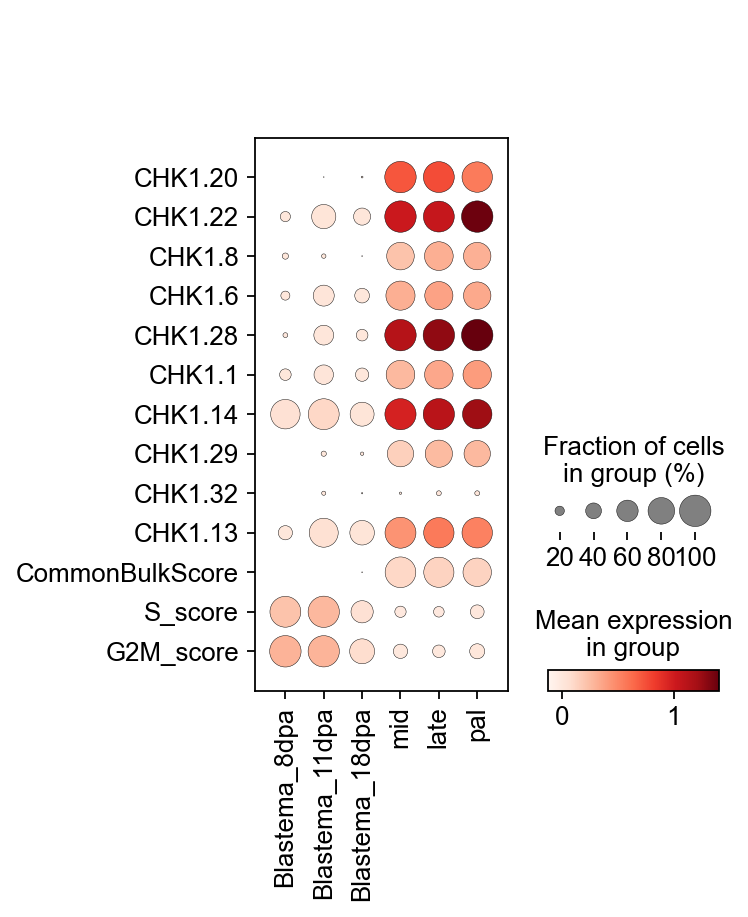

In [36]:

sc.pl.dotplot(axo,groupby="cellTypes", var_names=['S_score', 'G2M_score'],
              swap_axes=True,
              save="_CT_compare_CellCycle"
             )

sc.pl.dotplot(axo,groupby="cellTypes", var_names=['CHK1.20', 'CHK1.22','CHK1.8','CHK1.6','CHK1.28','CHK1.1','CHK1.14',
                       'CHK1.29','CHK1.32','CHK1.13','CommonBulkScore','S_score', 'G2M_score'],
              swap_axes=True,
              save="_CT_compare_senescenceScore"
             )


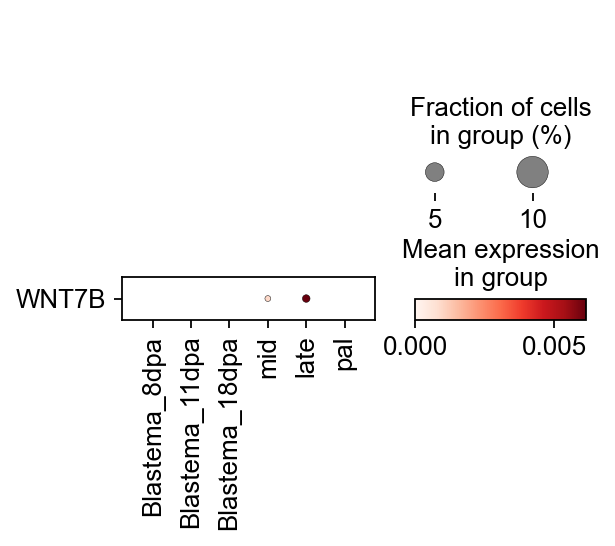

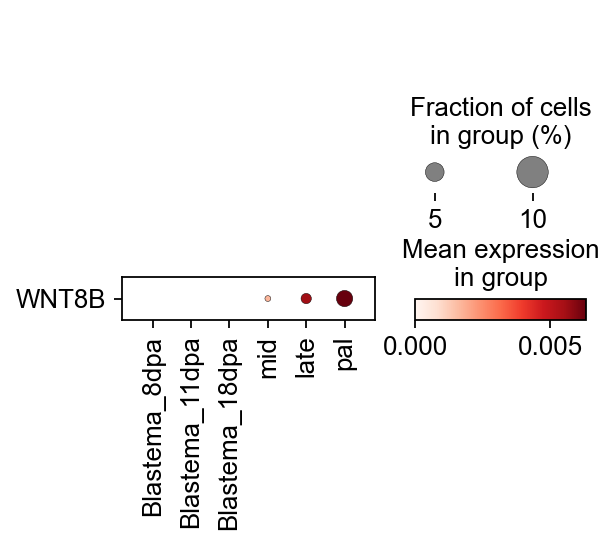

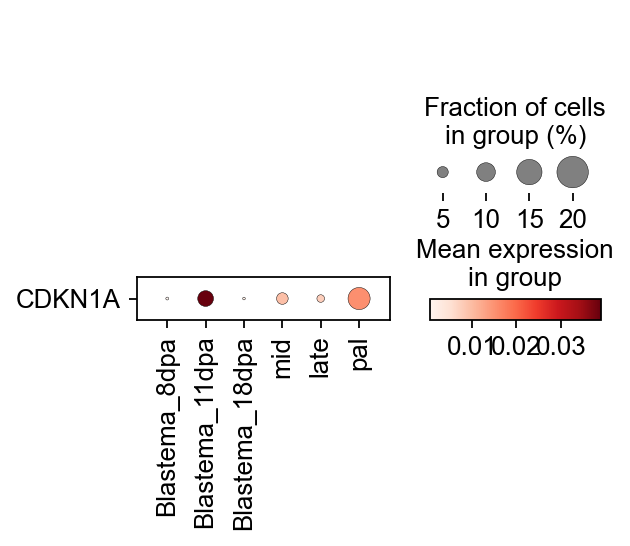

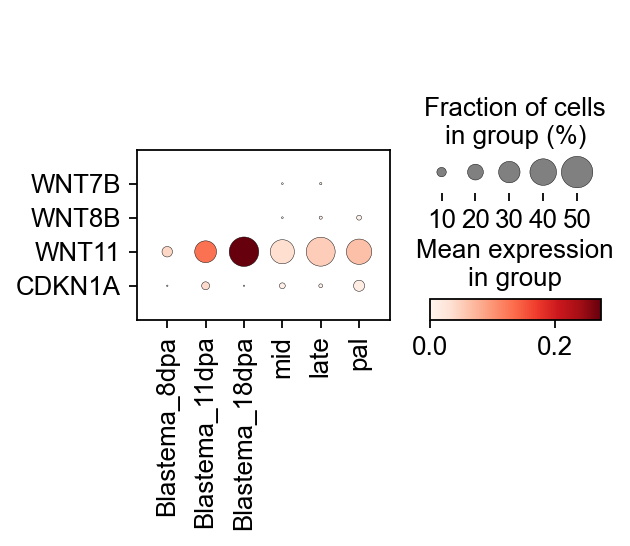

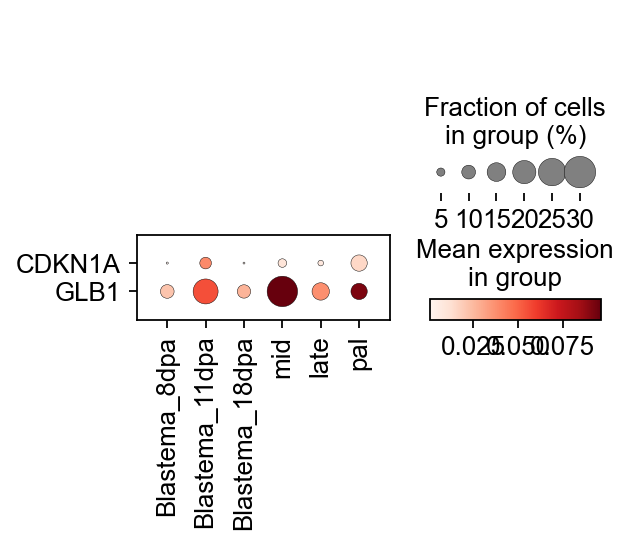

In [37]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names=['WNT7B'],
              swap_axes=True,
              save="_CT_WNT7B"
             )
sc.pl.dotplot(axo,groupby="cellTypes", var_names=['WNT8B'],
              swap_axes=True,
              save="_CT_WNT8B"
             )
sc.pl.dotplot(axo,groupby="cellTypes", var_names=['CDKN1A'],
              swap_axes=True,
              save="_CT_CDKN1A"
             )

sc.pl.dotplot(axo,groupby="cellTypes", var_names=['WNT7B','WNT8B','WNT11','CDKN1A'],
              swap_axes=True, dendrogram=False,
              save="_CT_compare_WNTpathway"
             )

sc.pl.dotplot(axo,groupby="cellTypes", var_names=['CDKN1A', 'GLB1'],
              swap_axes=True, dendrogram=False
             )

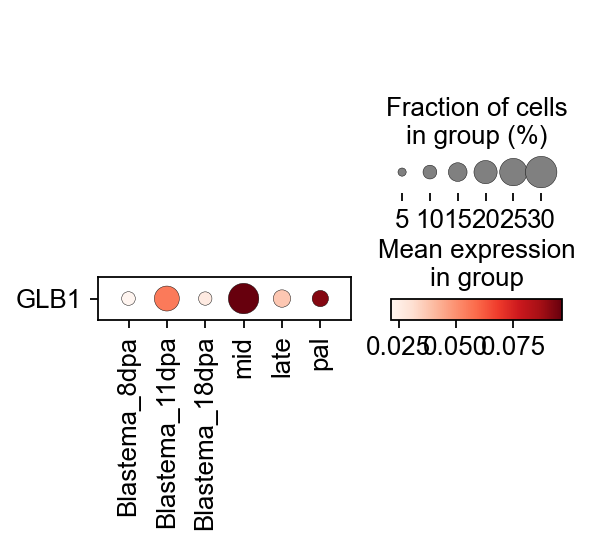

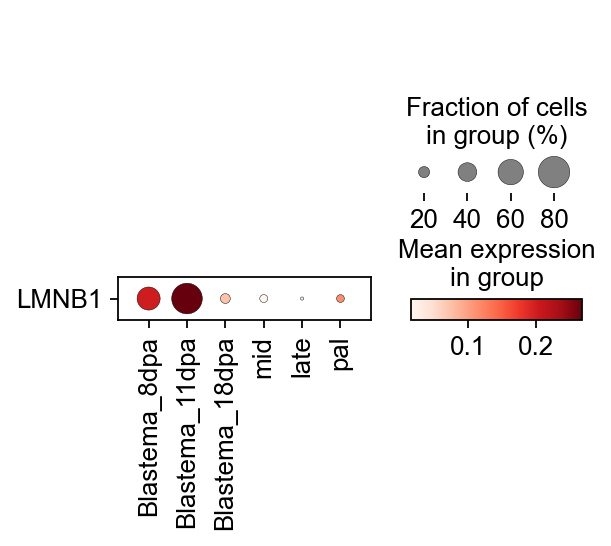

In [38]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names=['GLB1'],
              swap_axes=True, dendrogram=False,
              save="_CT_GLB1"
             )
sc.pl.dotplot(axo,groupby="cellTypes", var_names=['LMNB1'],
              swap_axes=True, dendrogram=False,
              save="_CT_LMNB1"
             )

Gene sets

In [87]:
SETS = pd.read_csv('../gene_sets/5ETS.txt', names=['5ETS'])
E2Ftargets = pd.read_csv('../gene_sets/E2Ftargets.txt', names=['E2Ftargets'])
Inflammatory = pd.read_csv('../gene_sets/Inflammatory.txt', names=['Inflammatory'])
ITS1 = pd.read_csv('../gene_sets/ITS1.txt', names=['ITS1'])
Lysosome = pd.read_csv('../gene_sets/Lysosome.txt', names=['Lysosome'])
NOTCH = pd.read_csv('../gene_sets/NOTCH.txt', names=['NOTCH'])
RibosomalProcessing = pd.read_csv('../gene_sets/Ribosome.txt', names=['RibosomalProcessing'])
rRNA = pd.read_csv('../gene_sets/rRNA_transcripts.txt', names=['rRNA'])
SASP = pd.read_csv('../gene_sets/SASP.txt', names=['SASP'])

In [39]:
SETS_genes = [x for x in axo.var_names if x in list(SETS.iloc[:,0])]
len(SETS_genes)

60

In [40]:
sc.tl.score_genes(axo, 
                      SETS_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='5ETS_score', 
                      random_state=0, copy=False, use_raw=False)

computing score '5ETS_score'
    finished: added
    '5ETS_score', score of gene set (adata.obs).
    698 total control genes are used. (0:00:00)


In [41]:
E2Ftargets_genes = [x for x in axo.var_names if x in list(E2Ftargets.iloc[:,0])]
len(E2Ftargets_genes)

164

In [42]:
sc.tl.score_genes(axo, 
                      E2Ftargets_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='E2Ftargets_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'E2Ftargets_score'
    finished: added
    'E2Ftargets_score', score of gene set (adata.obs).
    698 total control genes are used. (0:00:00)


In [43]:
Inflammatory_genes = [x for x in axo.var_names if x in list(Inflammatory.iloc[:,0])]
len(Inflammatory_genes)

438

In [44]:
sc.tl.score_genes(axo, 
                      Inflammatory_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='Inflammatory_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'Inflammatory_score'
    finished: added
    'Inflammatory_score', score of gene set (adata.obs).
    740 total control genes are used. (0:00:00)


In [45]:
ITS1_genes = [x for x in axo.var_names if x in list(ITS1.iloc[:,0])]
len(ITS1_genes)

10

In [46]:
sc.tl.score_genes(axo, 
                      ITS1_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='ITS1_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'ITS1_score'
    finished: added
    'ITS1_score', score of gene set (adata.obs).
    350 total control genes are used. (0:00:00)


In [47]:
Lysosome_genes = [x for x in axo.var_names if x in list(Lysosome.iloc[:,0])]
len(Lysosome_genes)

91

In [48]:
sc.tl.score_genes(axo, 
                      Lysosome_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='Lysosome_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'Lysosome_score'
    finished: added
    'Lysosome_score', score of gene set (adata.obs).
    644 total control genes are used. (0:00:00)


In [49]:
NOTCH_genes = [x for x in axo.var_names if x in list(NOTCH.iloc[:,0])]
len(NOTCH_genes)

131

In [50]:
sc.tl.score_genes(axo, 
                      NOTCH_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='NOTCH_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'NOTCH_score'
    finished: added
    'NOTCH_score', score of gene set (adata.obs).
    697 total control genes are used. (0:00:00)


In [82]:
RibosomalProcessing_genes = [x for x in axo.var_names if x in list(RibosomalProcessing.iloc[:,0])]
len(RibosomalProcessing_genes)

250

In [83]:
sc.tl.score_genes(axo, 
                      RibosomalProcessing_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='RibosomalProcessing_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'RibosomalProcessing_score'
    finished: added
    'RibosomalProcessing_score', score of gene set (adata.obs).
    647 total control genes are used. (0:00:00)


In [73]:
rRNA_genes = [x for x in axo.var_names if x in list(rRNA.iloc[:,0])]
len(rRNA_genes)

16

In [74]:
sc.tl.score_genes(axo, 
                      rRNA_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='rRNA_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'rRNA_score'
    finished: added
    'rRNA_score', score of gene set (adata.obs).
    299 total control genes are used. (0:00:00)


In [88]:
SASP_genes = [x for x in axo.var_names if x in list(SASP.iloc[:,0])]
len(SASP_genes)

64

In [89]:
sc.tl.score_genes(axo, 
                      SASP_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='SASP_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'SASP_score'
    finished: added
    'SASP_score', score of gene set (adata.obs).
    699 total control genes are used. (0:00:00)


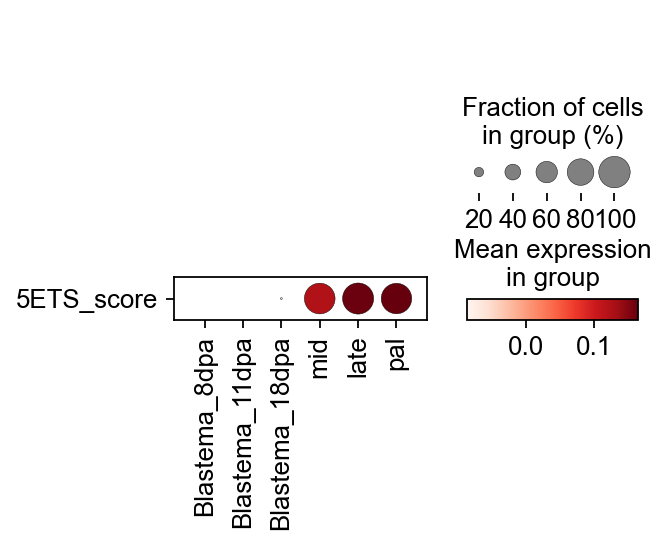

In [62]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names="5ETS_score",
              swap_axes=True, dendrogram=False,
              save="_CT_5ETS"
             )

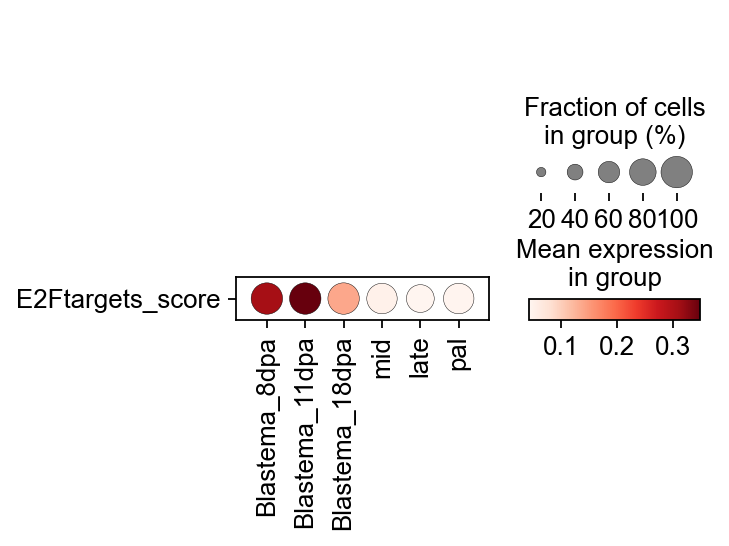

In [63]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names="E2Ftargets_score",
              swap_axes=True, dendrogram=False,
              save="_CT_E2Ftargets"
             )

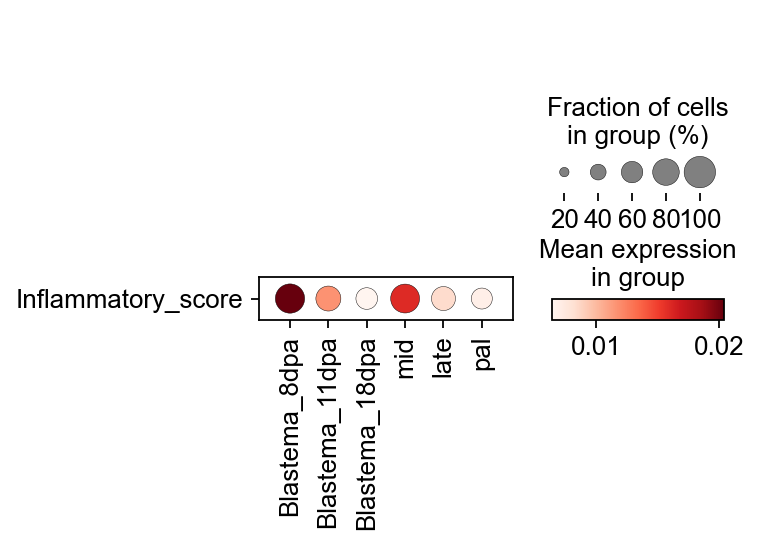

In [64]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names="Inflammatory_score",
              swap_axes=True, dendrogram=False,
              save="_CT_Inflammatory"
             )

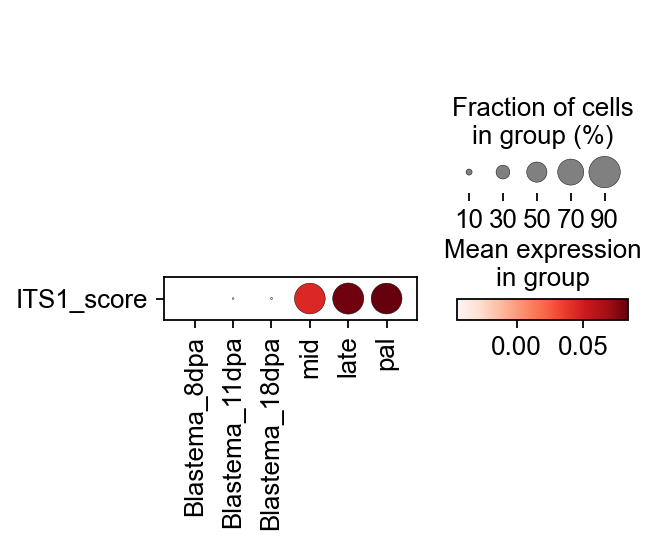

In [65]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names="ITS1_score",
              swap_axes=True, dendrogram=False,
              save="_CT_ITS1"
             )

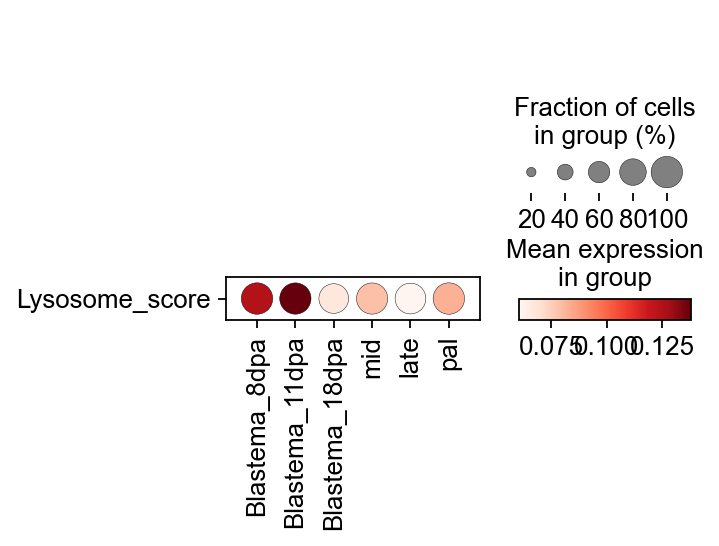

In [66]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names="Lysosome_score",
              swap_axes=True, dendrogram=False,
              save="_CT_Lysosome"
             )

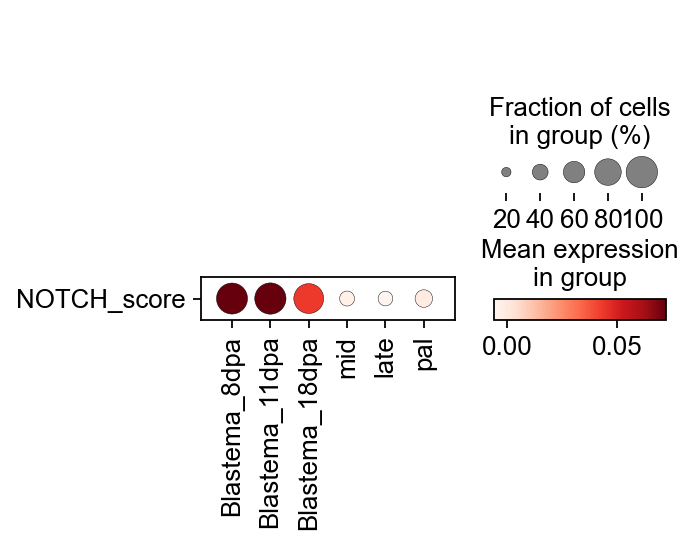

In [67]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names="NOTCH_score",
              swap_axes=True, dendrogram=False,
              save="_CT_NOTCH"
             )

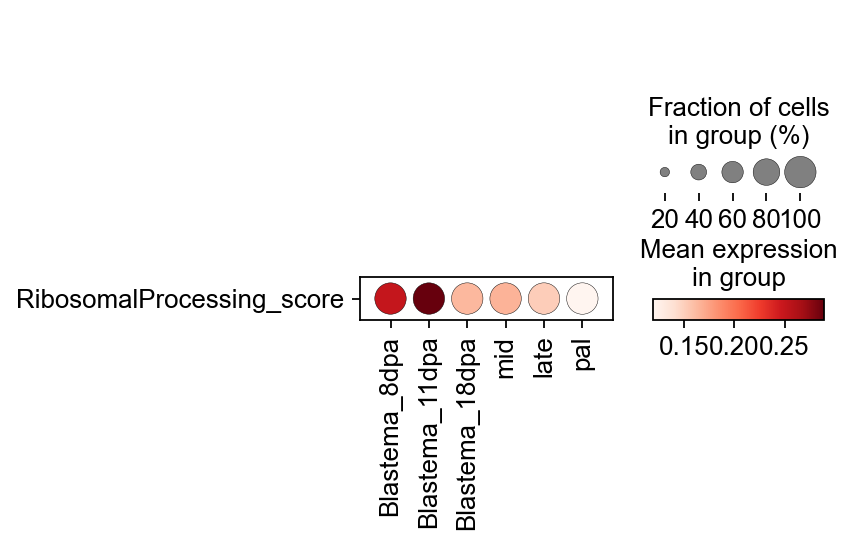

In [84]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names="RibosomalProcessing_score",
              swap_axes=True, dendrogram=False,
              save="_CT_Ribosome"
             )

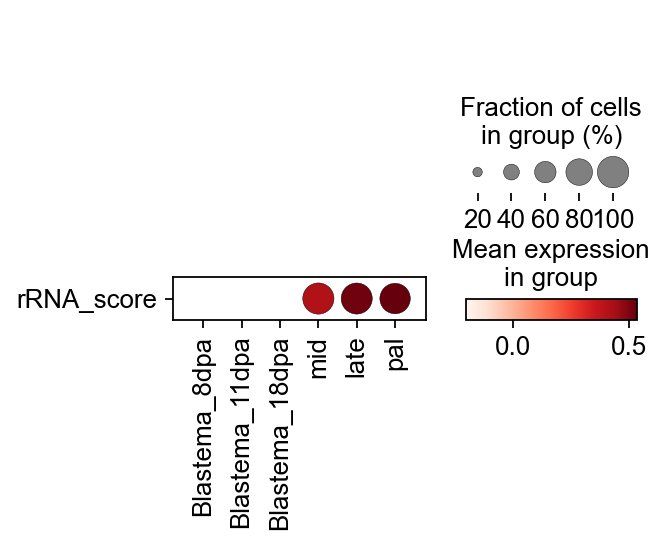

In [75]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names="rRNA_score",
              swap_axes=True, dendrogram=False,
              save="_CT_rRNA"
             )

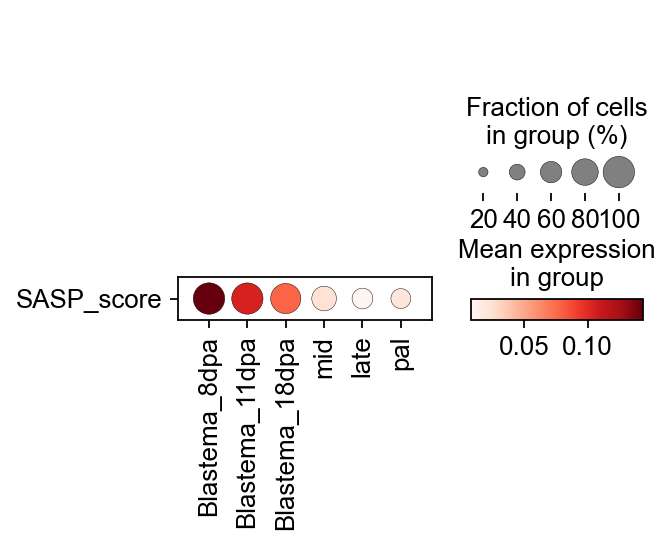

In [90]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names="SASP_score",
              swap_axes=True, dendrogram=False,
              save="_CT_SASP"
             )

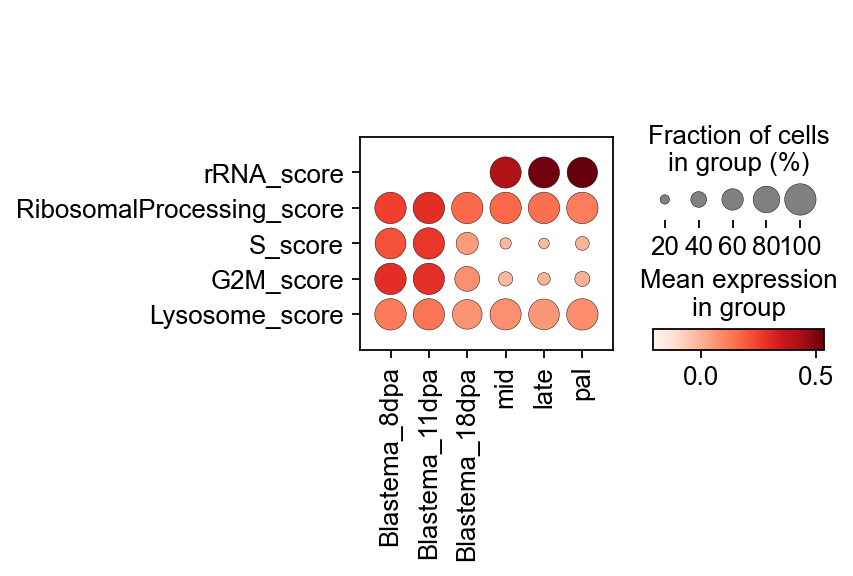

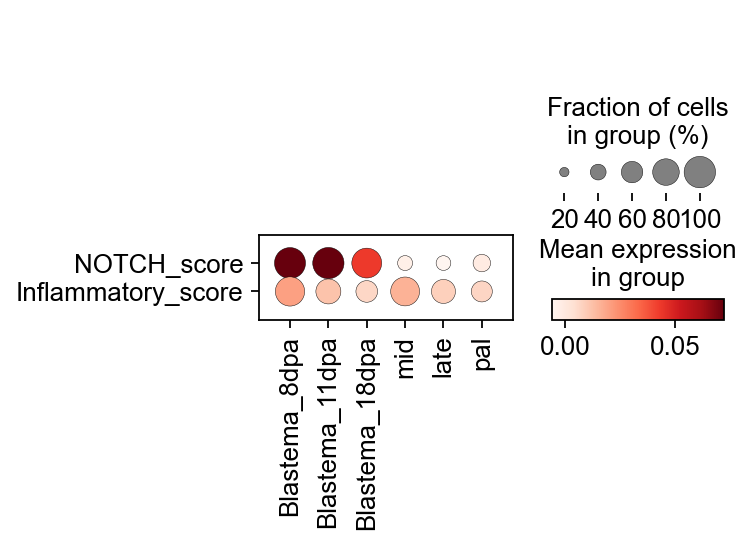

In [86]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names=['rRNA_score', 'RibosomalProcessing_score', 
                                                  'S_score',
                                                  'G2M_score',
                                                  'Lysosome_score'],
              swap_axes=True, dendrogram=False,
              save="_CT_all_sets"
             )

sc.pl.dotplot(axo,groupby="cellTypes", var_names=['NOTCH_score','Inflammatory_score'],
              swap_axes=True, dendrogram=False,
              save="_CT_NotchInfl"
             )

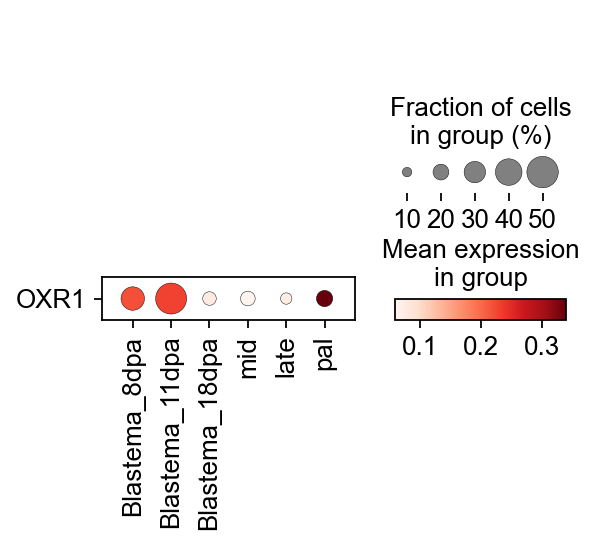

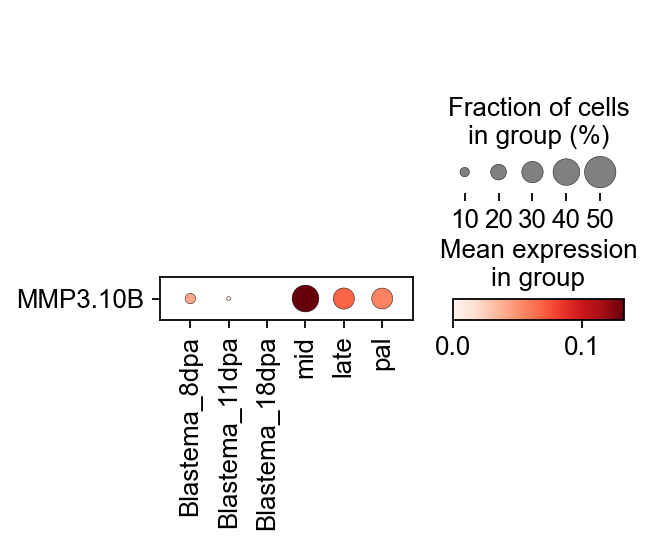

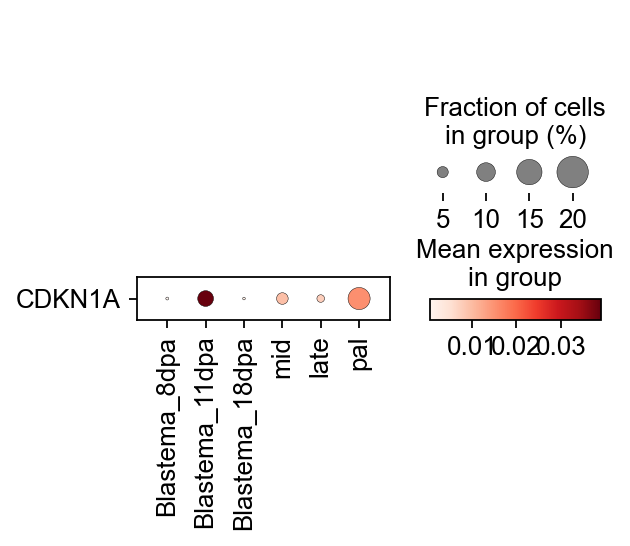

In [71]:
sc.pl.dotplot(axo,groupby="cellTypes", var_names=['OXR1'],
              swap_axes=True, dendrogram=False,
              save="_CT_OXR1"
             )
sc.pl.dotplot(axo,groupby="cellTypes", var_names=['MMP3.10B'],
              swap_axes=True, dendrogram=False,
              save="_CT_MMP3-10B"
             )
sc.pl.dotplot(axo,groupby="cellTypes", var_names=['CDKN1A'],
              swap_axes=True, dendrogram=False,
              save="_CT_CDKN1A"
             )